# Adaptive step-size selection for ODE filters


In ProbNum the step size adaptation scheme from [Schober et al., 2019](https://arxiv.org/pdf/1610.05261.pdf) respectively [Bosch et al., 2021](https://arxiv.org/pdf/2012.08202.pdf) is implemented.


In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../../probnum.mplstyle')

In [2]:
import numpy as np
from probnum import random_variables as rvs
from probnum.diffeq import probsolve_ivp

We begin by defining an ODE: the usual Lotka-Volterra problem.

In [3]:
def f(t, y):
    y1, y2 = y
    return np.array([0.5 * y1 - 0.05 * y1 * y2, -0.5 * y2 + 0.05 * y1 * y2])

def df(t, y):
    y1, y2 = y
    return np.array([[0.5 - 0.05 * y2, -0.05 * y1], [0.05 * y2, -0.5 + 0.05 * y1]])

t0 = 0.
tmax = 20.
y0 = np.array([20, 20])

### IBM(1) with EK0

We start by showing how solving an IVP with adaptive steps works.

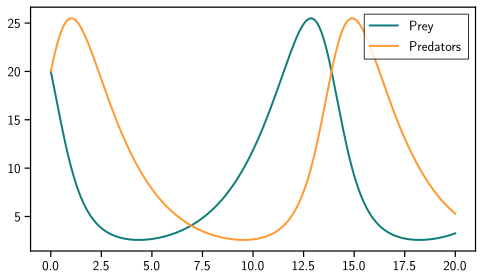

In [8]:
sol = probsolve_ivp(f, t0, tmax, y0, df=df, algo_order=2, method="EK1")

evalgrid = np.linspace(t0, tmax, 200)
means = sol(evalgrid).mean

plt.plot(evalgrid, means[:, 0], label="Prey")
plt.plot(evalgrid, means[:, 1], label="Predators")
plt.legend(loc="upper right")
plt.show()

Lets visualise the individual steps.

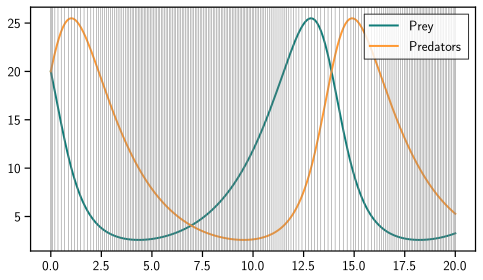

In [9]:
plt.plot(evalgrid, means[:, 0], label="Prey")
plt.plot(evalgrid, means[:, 1], label="Predators")
for t in sol.t:
    plt.axvline(t, linewidth=0.5, color="gray")
plt.legend(loc="upper right")
plt.show()

Note how more steps are taken near the peaks.

## The same, for a few setups

Let's consider how other priors fare in this setting.

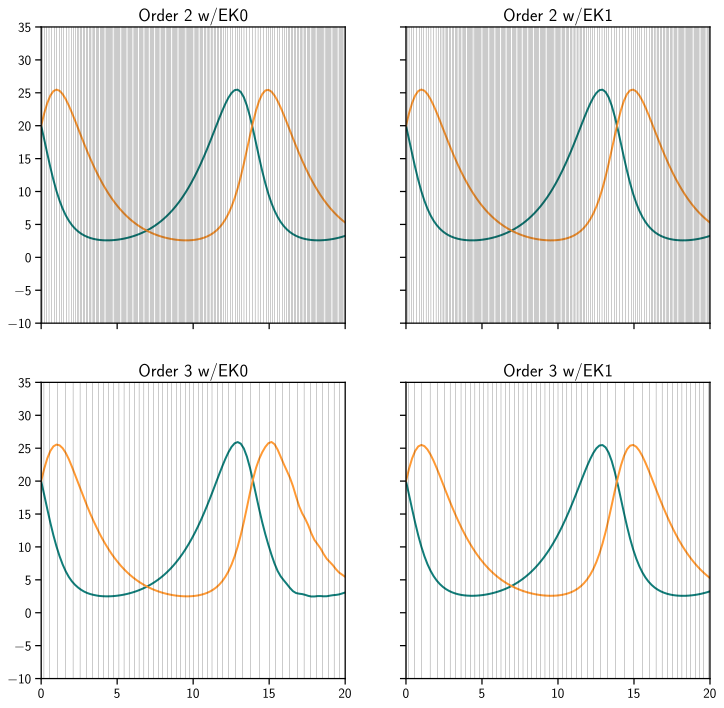

In [6]:
algo_orders = [2, 3]
filters = ["EK0", "EK1"]


fig, ax = plt.subplots(
    nrows=len(algo_orders), ncols=len(filters), sharex=True, sharey=True, figsize=(12, 12)
)

evalgrid = np.linspace(t0, tmax, 100)

for idx in range(len(algo_orders)):  # algo_orders in rows
    for jdx in range(len(filters)):  # filters in cols
        sol = probsolve_ivp(f, t0, tmax, y0, df=df,
            algo_order=algo_orders[idx],
            method=filters[jdx],
        )
              
        solution = sol(evalgrid)
        ts, means, stds = evalgrid, solution.mean, solution.std
        ax[idx][jdx].plot(ts, means)
        
        for t in sol.t:
            ax[idx][jdx].axvline(t, linewidth=0.2, color="black")
        ax[idx][jdx].set_title(f"Order {algo_orders[idx]} w/{filters[jdx]}")
        ax[idx][jdx].set_xlim((t0, tmax))
        ax[idx][jdx].set_ylim((-10, 35))

plt.show()

They all seem to capture the true solution fairly well. The higher order takes significantly fewer steps than the lower order.